In [1]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [2]:
# Basic usage
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


In [3]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [4]:
# Output is a dictionary
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [5]:
# Multiple inputs passed in as a list
classifier([
  "This course is just what I needed.",
  "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [7]:
import torch

In [10]:
#torch.cuda.is_available()
#torch.cuda.current_device()

In [11]:
df_ = pd.read_csv('AirlineTweets.csv')

In [12]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [23]:
df = df_[['airline_sentiment', 'text']].copy()

<Axes: >

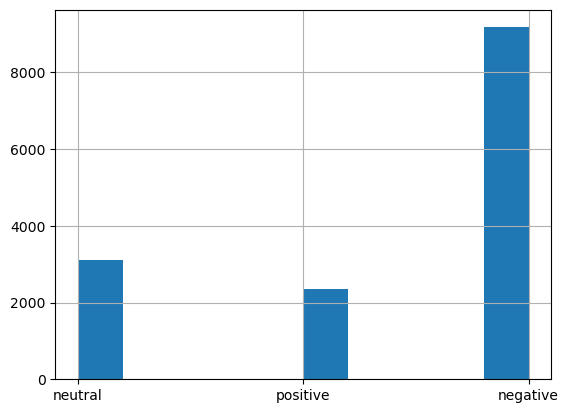

In [24]:
df['airline_sentiment'].hist()

In [25]:
df = df[df.airline_sentiment != 'neutral'].copy()

In [26]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [27]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [28]:
len(df)

11541

In [29]:
# takes too long to do prediction without gpu enabled, so lets try a sample!
df = df.sample(frac=0.05, replace=False, random_state=42)
len(df)

577

In [30]:
texts = df['text'].tolist()
predictions = classifier(texts)

In [35]:
probs = [d['score'] if d['label'].startswith('P') else 1 - d['score'] \
         for d in predictions]

In [36]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions]
preds = np.array(preds)
print("acc:", np.mean(df['target'] == preds))

acc: 0.8925476603119584


In [37]:
cm = confusion_matrix(df['target'], preds, normalize='true')
cm

array([[0.90254237, 0.09745763],
       [0.15238095, 0.84761905]])

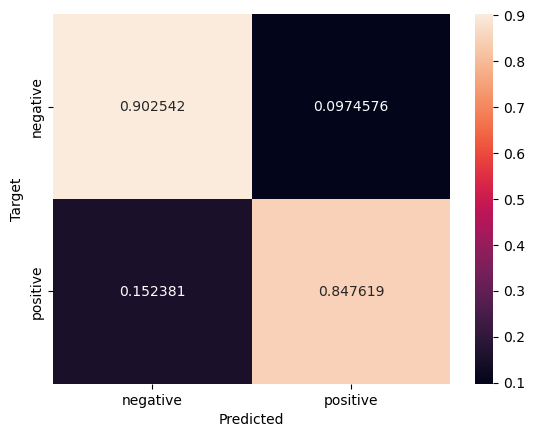

In [38]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [39]:
print('f1_score', f1_score(df['target'], preds))
print('f1_score_neg',f1_score(1 - df['target'], 1 - preds))
print('roc_score',roc_auc_score(df['target'], probs))
print('roc_score_neg',roc_auc_score(1 - df['target'], 1 - np.array(probs)))

f1_score 0.7416666666666667
f1_score_neg 0.9321663019693655
roc_score 0.9566182405165455
roc_score_neg 0.9566182405165455
